In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from shapely.geometry import Point, Polygon
from matplotlib.patches import Polygon as matplotlibPolygon
from multiprocessing import Pool, cpu_count
from shapely.affinity import scale
from shapely.strtree import STRtree
from scipy.spatial import ConvexHull

import json
from rtree import index

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered_new/"
polygon_dir  = "/data/projects/robin/segmentation/output-new-seg/segmentation_polygons.json"

with open(polygon_dir, 'r') as file:
    polygon_dict = json.load(file)

adata_with_domain = sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")

In [3]:
cell_names = [str(polygon_dict['geometries'][i]['cell']) for i in range(len(polygon_dict['geometries']))]
cell_coordinates = [polygon_dict['geometries'][i]['coordinates'][0] for i in range(len(polygon_dict['geometries']))]
cell_names = np.array(cell_names)
df_polygon = pd.DataFrame({
    'names' : cell_names,
    'coords' : cell_coordinates})
df_polygon.index = df_polygon['names']
df_polygon

,names,coords
names,,
185983,185983,"[[3714.5618, 20479.88], [3714.3374, 20482.264]..."
371966,371966,"[[7231.8833, 3040.58], [7232.0537, 3039.7822],..."
221120,221120,"[[7118.4053, 19706.914], [7115.494, 19704.934]..."
92533,92533,"[[1470.7107, 14148.667], [1470.7705, 14150.08]..."
76914,76914,"[[2689.5303, 12016.144], [2688.5042, 12016.396..."
...,...,...
300650,300650,"[[1215.121, 13696.862], [1213.2627, 13699.764]..."
150325,150325,"[[6032.6353, 14348.5], [6033.725, 14348.425], ..."
336545,336545,"[[7494.6553, 8513.94], [7494.7266, 8513.655], ..."


In [4]:
sample = 'X7'

# Read anndata
adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')

# Add "is_in_polygon" col. to the data
is_in_polygon = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'is_in_polygon']
nichepca_glom_no = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'nichepca_glom_no']
polygon_id = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'polygon_flags']
celltype_l1_prob = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'celltype_l1_prob']

adata.obs['is_in_polygon'] = list(is_in_polygon)
adata.obs['nichepca_glom_no'] = list(nichepca_glom_no)
adata.obs['polygon_id'] = list(polygon_id)
adata.obs['celltype_l1_prob'] = list(celltype_l1_prob)

# Restrict anndata to PECs in polygon
adata = adata[adata.obs['is_in_polygon']]
# adata = adata[adata.obs['celltype_l1'] == 'PEC']

print(adata.shape)

(4112, 480)


In [5]:
adata_all = adata.copy()

In [6]:
all_gloms = adata.obs['polygon_id'].unique()
all_gloms = [i for i in all_gloms if len(i.split(',')) < 2]
all_gloms

['0_0011186_SLE_X7_slide2',
 '1_0011186_SLE_X7_slide2',
 '2_0011186_SLE_X7_slide2',
 '3_0011186_SLE_X7_slide2',
 '4_0011186_SLE_X7_slide2',
 '5_0011186_SLE_X7_slide2']

Tcell_0_0011186_SLE_X7_slide2


962it [00:00, 1091.36it/s]


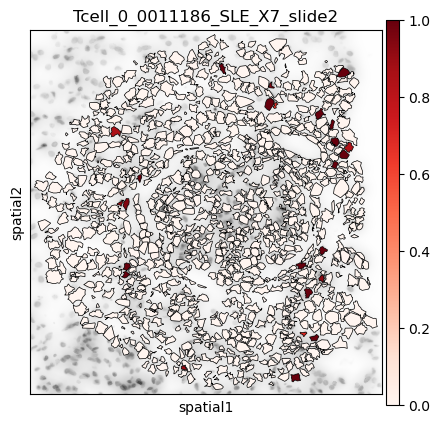

Tcell_1_0011186_SLE_X7_slide2


857it [00:00, 1135.21it/s]


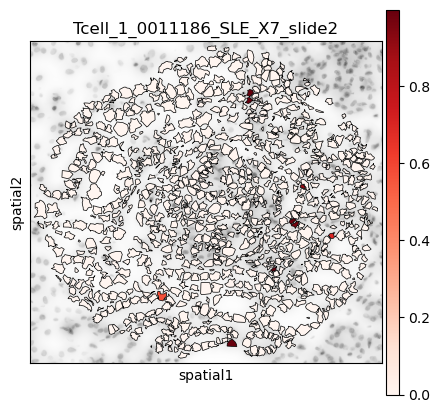

Tcell_2_0011186_SLE_X7_slide2


833it [00:00, 1155.15it/s]


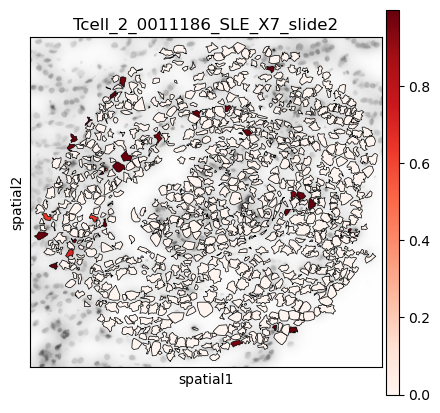

Tcell_3_0011186_SLE_X7_slide2


488it [00:00, 1092.09it/s]


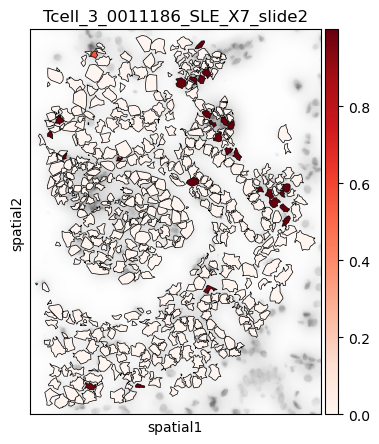

Tcell_4_0011186_SLE_X7_slide2


430it [00:00, 1288.62it/s]


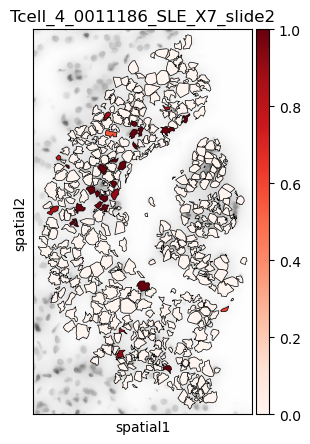

Tcell_5_0011186_SLE_X7_slide2


885it [00:00, 1230.83it/s]


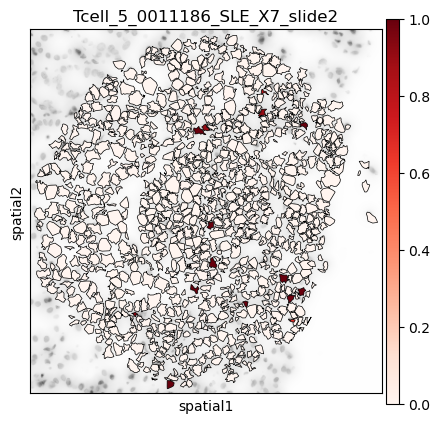

In [7]:
for glom in all_gloms:

    title = 'Tcell_' + glom
    print(title)
    adata = adata_all.copy()

    tokeep = []
    id = glom
    
    for i in adata.obs['polygon_id']:
        if i == id:
            tokeep.append(True)
        elif len(i.split(',')) > 0:
            flag = 0
            for j in i.split(','):
                if j == id:
                    flag = 1
                    break
            if flag == 1:
                tokeep.append(True)
            else:
                tokeep.append(False)        
        else:
            tokeep.append(False)

    adata = adata[tokeep]
    slide_id = adata.obs['Slide_ID'][0]

    # Get the cell that exsit in both anndata and cell boundries
    cell_name = [i.split('-')[1] for i in adata.obs.index]
    adata.obs['cell_name'] = cell_name
    adata = adata[adata.obs['cell_name'].isin(df_polygon['names'])]
    df_polygon_i = df_polygon.loc[adata.obs['cell_name']]

    # Get the shift to match cell poition on pixels
    adata.uns['spatial'][slide_id]['scalefactors']['tissue_dapi_LEVEL1_cropped_scalef'] = 1
    x_shift = adata.obs['x'][0] - adata.obsm['spatial'][0, 0]
    y_shift = adata.obs['y'][0] - adata.obsm['spatial'][0, 1]

    fig, ax = plt.subplots(figsize=(5, 5))
    
    adata.obs.loc[adata.obs['celltype_l1'] != 'T', 'celltype_l1_prob'] = 0
    
    sc.pl.spatial(adata,
                  library_id = slide_id,
                  img_key = ['Ki67', 'dapi_LEVEL1_cropped',None][1],
                  color = 'celltype_l1_prob',
                  size = 0,
                  ax = ax,
                  cmap='Reds',
                  title=title,
                  show = False,
                 )
    
    ki67_values = adata.obs['celltype_l1_prob'].values
    ki67_min, ki67_max = ki67_values.min(), ki67_values.max()
    normalized_values = (ki67_values - ki67_min) / (ki67_max - ki67_min)
    cmap = plt.get_cmap('Reds')
    colors = [cmap(value) for value in normalized_values]
    
    coords_all = np.array([]).reshape([0, 2])
    
    for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
        
        cell_name = idx.split('-')[1]
        coords = df_polygon_i.loc[cell_name, 'coords']
    
        coords = np.array(coords)
        coords[:,0] = coords[:,0] - x_shift
        coords[:,1] = coords[:,1] - y_shift
        coords_all = np.concatenate([coords_all, coords])
    
        polygon_obj = matplotlibPolygon(coords, 
                              facecolor=colors[n],
                              edgecolor="black",
                              alpha=1,
                              linewidth=0.5,
                             )
    
    
        ax.add_patch(polygon_obj)
    
    
    i_min, j_min = coords_all.min(axis=0) - 5
    i_max, j_max = coords_all.max(axis=0) + 5
    
    ax.set_xlim(i_min, i_max)
    ax.set_ylim(j_min, j_max)
    ax.invert_yaxis()
    
    plt.savefig(f"gloms/{title}.pdf", bbox_inches="tight")
    plt.show()
                

In [8]:
list(adata.obs['celltype_l1'].unique())

['EC',
 'FIB',
 'PT',
 'DCT',
 'PapE',
 'MDC',
 'IC',
 'Mono',
 'TAL',
 'T',
 'MAC',
 'PC',
 'CNT',
 'N',
 'mesangial cell',
 'NKC/T',
 'cycMNP',
 'VSM/P',
 'PEC',
 'MAST',
 'PL',
 'podocyte',
 'cycNKC/T',
 'DTL',
 'B',
 'ATL',
 'NEU']